In [95]:
import torch
import torch.nn as nn
import os
import numpy as np
from torch.utils.data import DataLoader, TensorDataset
import torch.nn.functional as F
from torch.optim import Adam
from torch.optim import LBFGS
import matplotlib.pyplot as plt
import pandas as pd

In [96]:
def activation(name):
    if name in ['tanh', 'Tanh']:
        return nn.Tanh()
    elif name in ['relu', 'ReLU']:
        return nn.ReLU(inplace=True)
    elif name in ['lrelu', 'LReLU']:
        return nn.LeakyReLU(inplace=True)
    elif name in ['sigmoid', 'Sigmoid']:
        return nn.Sigmoid()
    elif name in ['softplus', 'Softplus']:
        return nn.Softplus(beta=4)
    elif name in ['celu', 'CeLU']:
        return nn.CELU()
    elif name in ['elu']:
        return nn.ELU()
    elif name in ['mish']:
        return nn.Mish()
    else:
        raise ValueError('Unknown activation function')

################################################################
#  1d fourier layer
################################################################
class SpectralConv1d(nn.Module):
    def __init__(self, in_channels, out_channels, modes1):
        super(SpectralConv1d, self).__init__()

        """
        1D Fourier layer. It does FFT, linear transform, and Inverse FFT.    
        """

        self.in_channels = in_channels
        self.out_channels = out_channels
        self.modes1 = modes1

        self.scale = (1 / (in_channels * out_channels))
        self.weights1 = nn.Parameter(self.scale * torch.rand(in_channels, out_channels, self.modes1, dtype=torch.cfloat))

    # Complex multiplication
    def compl_mul1d(self, input, weights):
        # (batch, in_channel, x ), (in_channel, out_channel, x) -> (batch, out_channel, x)
        return torch.einsum("bix,iox->box", input, weights)

    def forward(self, x):
        # x.shape == [batch_size, in_channels, number of grid points]
        d = x.shape[2]
        # Compute Fourier coefficients
        x = torch.fft.rfft(x,dim=2)
        # Multiply Fourier modes
        x = self.compl_mul1d(x, self.weights1)
        # Return to physical space
        x = torch.fft.irfft(x, n=d)
        return x


####################################################################

class FNO1d(nn.Module):
    def __init__(self, modes, width):
        super(FNO1d, self).__init__()

        """
        The overall network. It contains 4 layers of the Fourier layer.
        1. Lift the input to the desire channel dimension by self.fc0 .
        2. 4 layers of the integral operators u' = (W + K)(u).
            W defined by self.w; K defined by self.conv .
        3. Project from the channel space to the output space by self.fc1 and self.fc2 .

        input: the solution of the initial condition and location (a(x), x)
        input shape: (batchsize, x=s, c=2)
        output: the solution of a later timestep
        output shape: (batchsize, x=s, c=1)
        """

        self.modes1 = modes
        self.width = width
        self.padding = 1  # pad the domain if input is non-periodic
        self.linear_p = nn.Linear(3, self.width)  # input channel is 2: (u0(x), x)

        self.spect1 = SpectralConv1d(self.width, self.width, self.modes1)
        self.spect2 = SpectralConv1d(self.width, self.width, self.modes1)
        self.spect3 = SpectralConv1d(self.width, self.width, self.modes1)
        self.lin0 = nn.Conv1d(self.width, self.width, 1)
        self.lin1 = nn.Conv1d(self.width, self.width, 1)
        self.lin2 = nn.Conv1d(self.width, self.width, 1)

        self.linear_q = nn.Linear(self.width, 32)
        self.output_layer = nn.Linear(32, 2)

        self.activation = torch.nn.Tanh()

    def fourier_layer(self, x, spectral_layer, conv_layer):
       # return self.activation(spectral_layer(x))
        return self.activation(spectral_layer(x) + conv_layer(x))
        
                       
    def linear_layer(self, x, linear_transformation):
        return self.activation(linear_transformation(x))

    def forward(self, x):
        # grid = self.get_grid(x.shape, x.device)
        # x = torch.cat((x, grid), dim=-1)
        x = self.linear_p(x)
        x = x.permute(0, 2, 1)
        # x = F.pad(x, [0, self.padding])  # pad the domain if input is non-periodic

        x = self.fourier_layer(x, self.spect1, self.lin0)
        x = self.fourier_layer(x, self.spect2, self.lin1)
        x = self.fourier_layer(x, self.spect3, self.lin2)

        # x = x[..., :-self.padding]  # pad the domain if input is non-periodic
        x = x.permute(0, 2, 1)

        x = self.linear_layer(x, self.linear_q)
        x = self.output_layer(x)
        return x


In [97]:
class DatasetTask3(TensorDataset):
    # https://pytorch.org/tutorials/beginner/data_loading_tutorial.html
    # devide data into 5 input/outpus pairs, for cycle prediction
    def __init__(self, tensor_data, window_len):
        self.tensor_data = tensor_data
        self.window_len = window_len    # size of input/output sequences

    def __len__(self):
        # gives number of input and output pairs. In our case it is 5.
        return int(len(self.tensor_data)/self.window_len) - 1
        # return (len(self.data) // self.seq_length) - 1

    def __getitem__(self, idx):
        # idx is index of individual input-output pair
        lower_end = idx*self.window_len
        upper_end = (idx + 1)*self.window_len
        inputs = self.tensor_data[lower_end:upper_end]
        outputs = self.tensor_data[upper_end:upper_end+self.window_len,1:]
        
        return inputs, outputs

In [98]:
def normalize(x):
    """ mins and maxs for backconversion in lists"""
    t= x[:,0]; Tf= x[:,1] ; Ts = x[:,2]
    
    max_t , max_Tf, max_Ts = t.max(), Tf.max(), Ts.max()
    min_t , min_Tf, min_Ts = t.min(), Tf.min(), Ts.min()
    
    normalized_data = torch.zeros_like(x)
    normalized_data[:, 0] = (t - min_t)/(max_t - min_t)
    normalized_data[:, 1] = (Tf - min_Tf)/(max_Tf - min_Tf)
    normalized_data[:, 2] = (Ts - min_Ts)/(max_Ts - min_Ts)

    return normalized_data, [min_t , min_Tf, min_Ts], [max_t , max_Tf, max_Ts]

def denormalize(x, min, max):
    data = torch.zeros_like(x)
    for i in range(len(min)):
        data[:,i]= x[:,i]*(max[i]- min[i])+ min[i]
    return data

def regularization(model, order):
    reg_loss = 0
    for name, param in model.named_parameters():
        if 'weight' in name or 'bias' in name:
            reg_loss = reg_loss + torch.norm(param, order)
    return reg_loss

def fit(model,epochs, optimizer, training_set, regularization_p):  
        history = list()
        l = torch.nn.MSELoss()
    
        for epoch in range(epochs):
            train_mse = 0.0
            for step, (input_batch, output_batch) in enumerate(training_set):
                def closure():
                    optimizer.zero_grad()
                    output_pred_batch = model(input_batch).squeeze(2)
                    loss = l(output_pred_batch, output_batch) + regularization_p *regularization(fno, 2)
                    loss.backward()
                    history.append(loss.item())
                    return loss
  
                optimizer.step(closure=closure)
                train_mse += history[-1] #loss.item() 
                
            train_mse /= len(training_set)
        
            scheduler.step()
        
            if epoch % freq_print == 0: print("######### Epoch:", epoch, " ######### Train Loss:", train_mse)
        Final_loss = round(history[-1],4)
        print('Final Loss: ', history[-1])
        return history
    
def plot_hist(hist):
    plt.figure()
    plt.grid(True, which="both", ls=":")
    plt.plot(np.arange(1, len(hist) + 1), hist, label="Train Loss")
    plt.xscale("log")
    plt.legend()

######### Epoch: 0  ######### Train Loss: 0.5700667507946491
######### Epoch: 25  ######### Train Loss: 0.0011091397609561682
Final Loss:  0.001000617048703134


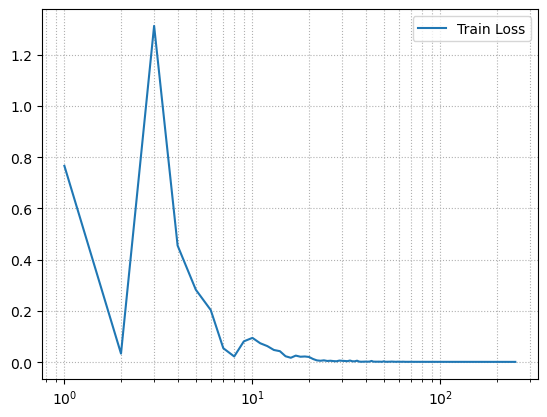

In [101]:
df = pd.read_csv('TrainingData.txt')
train_data = torch.tensor(df[['t','tf0', 'ts0']].values, dtype=torch.float)
train_data, mins, maxs = normalize(train_data)

window_len = 35
batch_size = 1
dataset = DatasetTask3(train_data, window_len)
training_set= torch.utils.data.DataLoader(dataset,batch_size=batch_size, shuffle=True)

learning_rate = 0.001

epochs = 50
freq_print = 25
modes = 18  # we do not truncate the fourier series, rDFT of vec 35 has length 18
width = 256 *2

fno = FNO1d(modes, width)

step_size = 50
gamma = 0.5

regularization_p =  1e-5

optimizer_Adam = Adam(fno.parameters(), lr=learning_rate, weight_decay=0)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer_Adam, step_size=step_size, gamma=gamma)

optimizer_LBFGS = LBFGS(fno.parameters(), lr=learning_rate, max_iter=50000, max_eval=50000, history_size=150, line_search_fn="strong_wolfe", tolerance_change=1.0 * np.finfo(float).eps)

hist = fit(fno, epochs,optimizer_Adam, training_set, regularization_p) # LBFGS does not support complex valued computations
plot_hist(hist)


torch.Size([34])


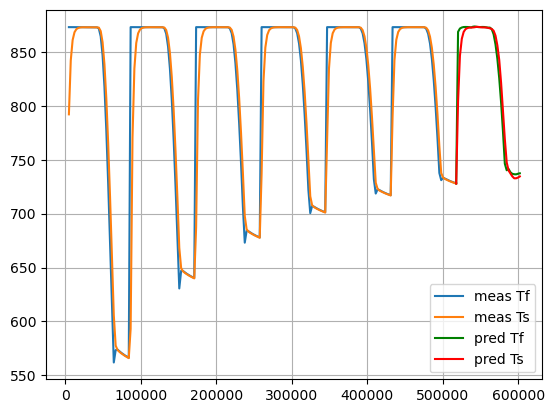

In [102]:
test_set = train_data[-window_len:,:].reshape(1,window_len,3)
output = fno(test_set).squeeze()

input_meas = denormalize(train_data, mins, maxs)
output = denormalize(output, mins[1:], maxs[1:])

df = pd.read_csv('TestingData.txt')
test_time = torch.tensor(df['t'].values, dtype=torch.float)
print(test_time.shape)

total_time = torch.cat([input_meas[:,0], test_time], 0)
total_pred = torch.cat([input_meas[:,1:], output.squeeze()[:-1]], 0)

plt.figure()
plt.plot(input_meas[2:,0].detach(), input_meas[2:,1].detach(),label='meas Tf')
plt.plot(input_meas[2:,0].detach(), input_meas[2:,2].detach(),label='meas Ts')
plt.plot(total_time[-window_len:].detach(), total_pred[-window_len:,0].detach(), label = 'pred Tf',color='green')
plt.plot(total_time[-window_len:].detach(), total_pred[-window_len:,1].detach(), label = 'pred Ts',color='red')
plt.grid('True')
plt.legend()
plt.show()

In [ ]:
test_df = pd.DataFrame({'t': test_time.numpy(), 'tf0': output[:-1,0].detach().numpy(), 'ts0': output[:-1,1].detach().numpy()})
test_df.to_csv(f'task3_epochs_{epochs}_width_{width}.txt', index=False)